【台北大學碩士班課程】淺度機器學習<br>
【授課老師】汪群超<br>
【學期】1112 <br>
【主要內容】分類器的原理與評比實驗：多元羅吉斯回歸<br>
【作者】711133117 陳怡升 <br>
【參考網站】[汪群超 Shallow Machine Lesson 8: 淺度機器學習：分類器的原理與評比實驗](https://ntpuccw.blog/sml-lesson-8-%e6%b7%ba%e5%ba%a6%e6%a9%9f%e5%99%a8%e5%ad%b8%e7%bf%92%ef%bc%9a%e5%88%86%e9%a1%9e%e5%99%a8%e7%9a%84%e5%8e%9f%e7%90%86%e8%88%87%e8%a9%95%e6%af%94%e5%af%a6%e9%a9%97/)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2, glob, time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

In [2]:
file = r'C:\Course\1112ShallowMachineLearning\data'

In [6]:
file = r'D:\711133117\1112ShallowMachineLearning\data'

In [3]:
def montage(A, m, n, sz):
    if type(A)==pd.core.frame.DataFrame:
        A = np.array(A)
    M = np.zeros((m*sz[0], n*sz[1])) # montage image
    for i in range(0,m):
        for j in range(0,n):
            M[i*sz[0]:(i+1)*sz[0], j*sz[1]:(j+1)*sz[1]] = A[i*n+j,:].reshape(sz[0], sz[1])
    return M

# 資料探索

In [4]:
import scipy.io
D = scipy.io.loadmat(file + r'\allFaces.mat')
X = pd.DataFrame(D['faces'].T) # each column represents an image
y = np.ndarray.flatten(D['nfaces'])
m = int(D['m'])
n = int(D['n'])
n_persons = int(D['person'])

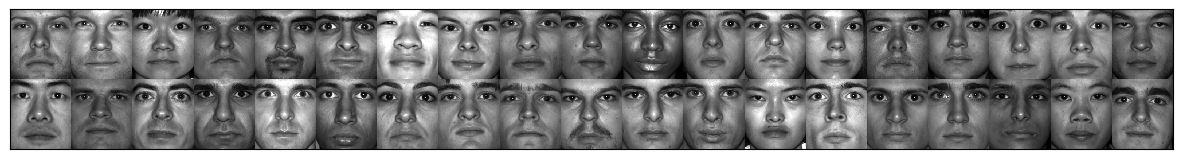

In [5]:
sz = np.array((192, 168)) 
plt.figure(figsize=(15,15))
M = montage(X.loc[np.pad(y.cumsum()[:-1],(1,0)),:], 19, 2, sz[::-1]).T
plt.imshow(M, cmap=plt.cm.gray , interpolation='nearest')
plt.xticks ([]), plt.yticks ([])
plt.show()

# 比較資料設定，切分 Train 和 Test

## 原始資料（有標準化）

In [6]:
X = pd.DataFrame(D['faces'].T)
y = np.repeat(range(0,len(D['nfaces'][0])), repeats=D['nfaces'][0])

In [7]:
# Split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [8]:
# Standardize data
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.fit_transform(X_test)

## 主成分資料

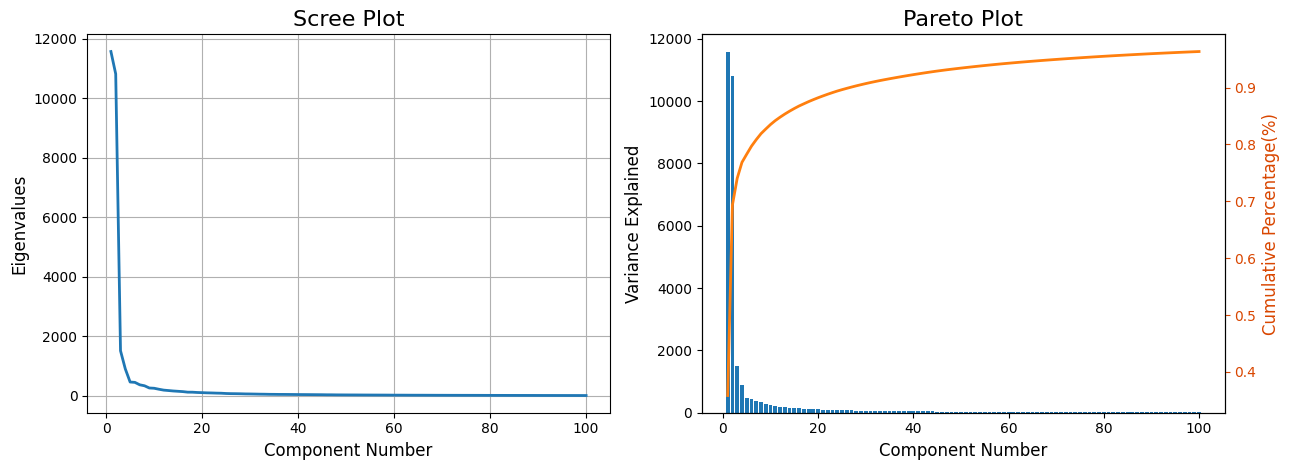

CPU times: total: 30.8 s
Wall time: 3.62 s


In [9]:
%%time

pca = PCA(n_components=100).fit(X_train_)

fig, axes = plt.subplots(ncols=2, figsize=(13,4.8))
x = np.arange(1,1+len(pca.explained_variance_))
axes[0].plot(x, pca.explained_variance_, lw=2)
# axes[0].set_xticks(x)
axes[0].set_xlabel('Component Number', fontsize=12)
axes[0].set_ylabel('Eigenvalues', fontsize=12)
axes[0].grid(True)
axes[0].set_title('Scree Plot', fontsize=16)

axes[1].bar(x, pca.explained_variance_)
ax2 = axes[1].twinx()
ax2.plot(x, pca.explained_variance_ratio_.cumsum(), color='C1', lw=2)
ax2.tick_params(axis='y', colors='#D94600')
ax2.set_ylabel('Cumulative Percentage(%)', fontsize=12, color="#D94600")
axes[1].set_xlabel('Component Number', fontsize=12)
axes[1].set_ylabel('Variance Explained', fontsize=12)
axes[1].set_title('Pareto Plot', fontsize=16)

plt.tight_layout()
plt.show()

In [16]:
print("取 {} 個變數，解釋程度有達到 90 %".format(sum(pca.explained_variance_ratio_.cumsum() < 0.9)+1))
n_comp = sum(pca.explained_variance_ratio_.cumsum() < 0.9)+1

取 27 個變數，解釋程度有達到 90 %


In [17]:
%%time

pca = PCA(n_components = n_comp).fit(X_train_)
Z_train = pca.transform(X_train_)
Z_test = pca.transform(X_test_)

CPU times: total: 22.1 s
Wall time: 2.3 s


# 比較資料之間的運算效率及準確度

以多元羅吉斯回歸為例
## 原始資料有標準化

In [ ]:
opts = dict(tol = 0.000001, max_iter = int(1e6))

train = X_train_;test = X_test_
df_want = pd.DataFrame()

for solver in ['lbfgs', 'liblinear', 'newton-cg']:
    start_time = time.time()
    logistic_org = LogisticRegression(solver = solver, **opts)
    logistic_org.fit(train, y_train)
    y_pred = logistic_org.predict(test)
    end_time = time.time()
    # 紀錄要用的資訊
    tmpdf = pd.DataFrame(data = {'Method':['Logistic'], 'accuracy':[accuracy_score(y_test, y_pred)], 
          'f1score':[f1_score(y_test, y_pred, average='weighted')], 
          'time':[(end_time - start_time)], 
          'solver':[solver]})
    df_want = pd.concat([df_want, tmpdf], ignore_index=True)

## 27個主成分資料

In [ ]:
opts = dict(tol = 0.000001, max_iter = int(1e6))

train = Z_train; test =Z_test
df_want = pd.DataFrame()

for solver in ['lbfgs', 'liblinear', 'newton-cg']:
    start_time = time.time()
    logistic_org = LogisticRegression(solver = solver, **opts)
    logistic_org.fit(train, y_train)
    y_pred = logistic_org.predict(test)
    end_time = time.time()
    # 紀錄要用的資訊
    tmpdf = pd.DataFrame(data = {'Method':['Logistic'], 'accuracy':[accuracy_score(y_test, y_pred)], 
          'f1score':[f1_score(y_test, y_pred, average='weighted')], 
          'time':[(end_time - start_time)], 
          'solver':[solver]})
    df_want = pd.concat([df_want, tmpdf], ignore_index=True)

# 分類器參數設定



## 多元羅吉斯迴歸

可以調整不同的演算法

- liblinear：適合小的資料集

In [84]:
opts = dict(tol = 0.000001, max_iter = int(1e6))

train = Z_train; test =Z_test
df_want = pd.DataFrame()

for solver in ['lbfgs', 'liblinear', 'newton-cg']:
    start_time = time.time()
    logistic_org = LogisticRegression(solver = solver, **opts)
    logistic_org.fit(train, y_train)
    y_pred = logistic_org.predict(test)
    end_time = time.time()
    # 紀錄要用的資訊
    tmpdf = pd.DataFrame(data = {'Method':['Logistic'], 'accuracy':[accuracy_score(y_test, y_pred)], 
          'f1score':[f1_score(y_test, y_pred, average='weighted')], 
          'time':[(end_time - start_time)], 
          'solver':[solver]})
    df_want = pd.concat([df_want, tmpdf], ignore_index=True)

In [85]:
df_want

,Method,accuracy,f1score,time,parameter,data
0,Logistic,0.866667,0.868418,0.006982,lbfgs,PCA
1,Logistic,0.888889,0.892271,0.001997,liblinear,PCA
2,Logistic,0.866667,0.868418,0.009006,newton-cg,PCA


## 支援向量機
- kernel : 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'<br>
其中ploy的Degree可以從degree調整
- gamma : 'scale', 'auto'
- decision_function_shape : 'ovr', 'ovo', defualt 'ovr'

In [107]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 
              'decision_function_shape':('ovr','ovo'), 'C':[1, 10]}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=parameters, cv=cv)
grid.fit(train, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 1, 'decision_function_shape': 'ovr', 'kernel': 'linear'} with a score of 0.99


In [109]:
grid.cv_results_

{'mean_fit_time': array([0.001197  , 0.0009974 , 0.00119667, 0.00099735, 0.00079784,
        0.00059838, 0.0009973 , 0.00079789, 0.00079789, 0.0009974 ,
        0.00079784, 0.00079794, 0.00079789, 0.00099735, 0.00099978,
        0.00099721]),
 'std_fit_time': array([3.98922109e-04, 1.90734863e-07, 3.98731232e-04, 2.33601546e-07,
        3.98921967e-04, 4.88577633e-04, 2.61174468e-07, 3.98945819e-04,
        3.98945848e-04, 1.90734863e-07, 3.98921995e-04, 3.98969665e-04,
        3.98945848e-04, 2.33601546e-07, 5.07915517e-06, 1.16800773e-07]),
 'mean_score_time': array([0.00059824, 0.00079789, 0.00059843, 0.00019941, 0.00039897,
        0.00039902, 0.00039892, 0.00039897, 0.00039892, 0.00019941,
        0.00019946, 0.00039892, 0.00039892, 0.00059838, 0.00039649,
        0.00039897]),
 'std_score_time': array([0.00048846, 0.00039895, 0.00048862, 0.00039883, 0.00048864,
        0.00048869, 0.00048858, 0.00048864, 0.00048858, 0.00039883,
        0.00039892, 0.00048858, 0.00048858, 0.000488

In [98]:
train = Z_train; test =Z_test
df_want = pd.DataFrame()
for dfs in ['ovr','ovo']:
    opts = dict(C = 1, tol = 0.000001, max_iter = int(1e6), decision_function_shape=dfs, degree=3)
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        start_time = time.time()
        svm = SVC(kernel=kernel, **opts)
        svm.fit(train, y_train)
        y_pred = svm.predict(test) 
        end_time = time.time()
        # 紀錄要用的資訊
        tmpdf = pd.DataFrame(data = {'Method':['SVM'], 'accuracy':[accuracy_score(y_test, y_pred)], 
          'f1score':[f1_score(y_test, y_pred, average='weighted')], 
          'time':[(end_time - start_time)], 
          'dfs':[dfs], 'kernel':[kernel]})
        df_want = pd.concat([df_want, tmpdf], ignore_index=True)

In [99]:
df_want

,Method,accuracy,f1score,time,dfs,kernel
0,SVM,0.911111,0.912835,0.002029,ovr,linear
1,SVM,0.844444,0.846409,0.000998,ovr,poly
2,SVM,0.933333,0.934695,0.001995,ovr,rbf
3,SVM,0.933333,0.933228,0.001995,ovr,sigmoid
4,SVM,0.911111,0.912835,0.002024,ovo,linear
5,SVM,0.844444,0.846409,0.000998,ovo,poly
6,SVM,0.933333,0.934695,0.000992,ovo,rbf
7,SVM,0.933333,0.933228,0.000998,ovo,sigmoid


## 神經網路
- activation : 'identity', 'logistic', 'tanh', 'relu'
- solver : 'lbfgs', 'sgd', 'adam'

In [103]:
train = Z_train; test = Z_test
df_want = pd.DataFrame()
for N in range(5, 21, 5):
    for activation in ['identity', 'logistic', 'tanh', 'relu']:
        opts = dict(hidden_layer_sizes=(N, ), activation=activation, tol=0.000001, max_iter=int(1e6))
        for solver in ['lbfgs', 'sgd', 'adam']:
            start_time = time.time()
            svm = MLPClassifier(solver=solver, **opts)
            svm.fit(train, y_train)
            y_pred = svm.predict(test) 
            end_time = time.time()
            # 紀錄要用的資訊
            tmpdf = pd.DataFrame(data = {'Method':['NN'], 'accuracy':[accuracy_score(y_test, y_pred)], 
              'f1score':[f1_score(y_test, y_pred, average='weighted')], 
              'time':[(end_time - start_time)], 
              'activation':[activation], 'solver':[solver], '神經元個數':[N]})
            df_want = pd.concat([df_want, tmpdf], ignore_index=True)

In [104]:
df_want

,Method,accuracy,f1score,time,activation,solver,神經元個數
0,NN,0.844444,0.844232,0.036929,identity,lbfgs,5
1,NN,0.888889,0.889894,1.978744,identity,sgd,5
2,NN,0.933333,0.933111,1.942773,identity,adam,5
3,NN,0.866667,0.866726,0.031914,logistic,lbfgs,5
4,NN,0.866667,0.868418,4.923831,logistic,sgd,5
5,NN,0.911111,0.912835,2.319828,logistic,adam,5
6,NN,0.911111,0.912835,0.017951,tanh,lbfgs,5
7,NN,0.888889,0.889894,3.929459,tanh,sgd,5
8,NN,0.866667,0.868418,1.700452,tanh,adam,5
9,NN,0.911111,0.909899,0.030917,relu,lbfgs,5


# 不同資料之間與不同分類器的比較

分別將 3 種資料帶入 3 種不同的分類器進行比較。

- 3 種資料：無標準化的原始資料、標準化的原始資料及主成分資料
- 3 種分類器：多元羅吉斯迴歸、支援向量機（SVM）、神經網路（NN）

In [ ]:
for data in ['沒有標準化', '原始資料標準化', 'PCA']:
    if data == '沒有標準化':
        train = X_train; test =X_test
    elif data == '原始資料標準化':
        train = X_train_; test =X_test_
    else :
        

In [ ]:
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)